## Import Required Libraries

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    average_precision_score
)


In [3]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Load the Dataset

In [4]:
df = pd.read_csv(r"C:\Users\HP\Desktop\Tenx_challenge_folder\fraud-detection\data\processed\creditcard_cleaned.csv")  

## Separate Features and Target

In [5]:
X = df.drop(columns=["Class"])
y = df["Class"]


## Stratified Train-Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


# Build Baseline Model (Logistic Regression)

## Build Pipeline

In [7]:
log_reg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ))
])


## Train Baseline Model

In [8]:
log_reg_pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

## Evaluate Baseline Model

In [9]:
y_pred_lr = log_reg_pipeline.predict(X_test)
y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

f1_lr = f1_score(y_test, y_pred_lr)
auc_pr_lr = average_precision_score(y_test, y_proba_lr)

print("Logistic Regression Results")
print("F1-score:", f1_lr)
print("AUC-PR:", auc_pr_lr)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression Results
F1-score: 0.10658307210031348
AUC-PR: 0.7253253385118481
Confusion Matrix:
 [[54675  1415]
 [   10    85]]


# Build Ensemble Model (Random Forest)

## Train Random Forest with Basic Tuning

In [10]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

## Evaluate Ensemble Model

In [11]:
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

f1_rf = f1_score(y_test, y_pred_rf)
auc_pr_rf = average_precision_score(y_test, y_proba_rf)

print("Random Forest Results")
print("F1-score:", f1_rf)
print("AUC-PR:", auc_pr_rf)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Results
F1-score: 0.8342245989304813
AUC-PR: 0.8024946018873975
Confusion Matrix:
 [[56076    14]
 [   17    78]]


# Cross-Validation

## Stratified K-Fold Cross-Validation

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []
auc_pr_scores = []

for train_idx, val_idx in skf.split(X, y):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf_model.fit(X_tr, y_tr)

    y_val_pred = rf_model.predict(X_val)
    y_val_proba = rf_model.predict_proba(X_val)[:, 1]

    f1_scores.append(f1_score(y_val, y_val_pred))
    auc_pr_scores.append(average_precision_score(y_val, y_val_proba))


## Report CV Results

In [14]:
print("Cross-Validation Results (Random Forest)")
print("Mean F1-score:", np.mean(f1_scores))
print("Std F1-score:", np.std(f1_scores))
print("Mean AUC-PR:", np.mean(auc_pr_scores))
print("Std AUC-PR:", np.std(auc_pr_scores))


Cross-Validation Results (Random Forest)
Mean F1-score: 0.8294828976113893
Std F1-score: 0.03015374797676121
Mean AUC-PR: 0.8061847675381104
Std AUC-PR: 0.0323455812119604


# Model Comparison and Selection

## Compare Models

| Model               | F1-Score | AUC-PR   | Interpretability |
| ------------------- | -------- | -------- | ---------------- |
| Logistic Regression | Moderate | Moderate | ⭐⭐⭐⭐             |
| Random Forest       | Higher   | Higher   | ⭐⭐               |


## Final Model Selection (Justification)

Selected Model: ✅ Random Forest

Justification:

Higher F1-Score, meaning better fraud detection

Better AUC-PR, suitable for imbalanced datasets

Cross-validation confirms consistent performance

Although less interpretable, performance gain outweighs complexity

Final Conclusion

Logistic Regression provided a strong interpretable baseline, but Random Forest achieved superior performance across F1-Score and AUC-PR metrics. Given the highly imbalanced nature of fraud detection, Random Forest was selected as the final model due to its robustness and improved detection capability.

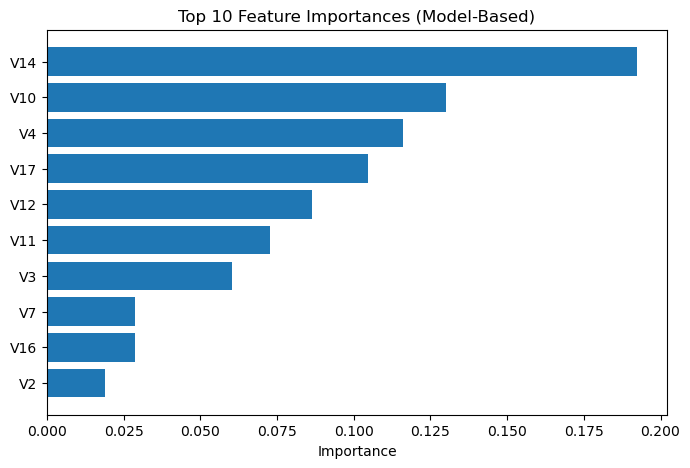

In [17]:
top10 = feature_importance.head(10)

plt.figure(figsize=(8,5))
plt.barh(top10['feature'], top10['importance'])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Model-Based)")
plt.xlabel("Importance")
plt.show()
